# PolyQ Rotamers Analysis  - A4_Q12_DES-amber

### Libraries of interest 

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import pandas as pd
import mdtraj as md
import scipy.stats as st
import nglview as nv
import MDAnalysis as mda
from nglview.datafiles import PDB,XTC
from scipy.spatial.distance import cdist
%matplotlib inline
import os
import matplotlib.pyplot as plt
from matplotlib import cm
#from scipy.stats import gaussian_kde
from Bio.SeqUtils import IUPACData
from __future__ import print_function
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import itertools
import mdtraj.testing
from itertools import product

### Kernel density estimation

In [2]:
class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

### Upload the trajectories

First, we uploaded the topology (trajectory and pdb) and saved as "t". 

In [3]:
dirname = f'/home/lourdes/TFM-LOURDES/data/ALL/A4_Q12_DES-amber'
temp = 1 
equil = 0
topname = os.path.join(dirname, 'prot.pdb')
trajname = os.path.join(dirname, f'prod{temp}_prot.xtc')
t = md.load(trajname, top=topname, stride=1)
t = t[equil:]
t.remove_solvent(inplace=True)
print (t)

<mdtraj.Trajectory with 20001 frames, 377 atoms, 24 residues, and unitcells>


### Secondary structure: Helicity 

When we have the topology, we can calculate the helicity (secondary structure of each amino acid) using the "md.compute_dssp" function. We have obtained an array (nº of frames, nº of residues) with "H" or 1 when the residue is helical and "C" or 0 when the residue is coil.  

In [4]:
####HELICITY
ss = md.compute_dssp(t,simplified=True)
ssh = (ss=='H').astype(np.float)
ssc = (ss=='C').astype(np.float)

print (ssh.shape)
print (ssc.shape)

print (ssh)
print (ssc)

(20001, 24)
(20001, 24)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


### Q1-L1 distance: hydrogen bond formation

Here, we are going to calculate the distance between the Q1 and the L1. It is to important to keep in mind that the hydrogen bond distance is 2-3 A. 

In [5]:
#Calculate the distance between the Q1 (sc) and L1 (mc)
#These are the potential donor atom names.
#Selecting the hydrogens of Q1
donors = t.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
if donors.size==0: 
    np.array([9999.])
#Selecting the oxigen of L1
acceptor = t.topology.select('residue 7 and name O')
pairs = list(product(donors, acceptor))
d = md.compute_distances(t, pairs)
#We take the shortest distance
d = d.min(1)
d *= 10 #to angstroms

print (d)
print (len(d))

[12.466469  12.878645  12.176133  ...  4.2991753  4.892055   4.752862 ]
20001


### Selection of new trajectories/topologies of interest 

Now we can also select the frames where a determinated condition is fullfiled. For example, we are going to focus our studies in the different rotamers population depending on whether the residues are helical or not/are forming the sc-mc hydrogen bond or not. 

In [7]:
#select some different trajectories 

# new trajectory where the residues 7 to 11 are helical 
t_helix = t[np.all(ssh[:,6:10]>0,1)]
print (t_helix)


# new trajectory where the residues 19 to 22 are not helical (coil)
t_coil = t[np.all(ssc[:,18:21]>0,1)]
print (t_coil)

# new trajectory where the L1-Q1 distance is < 2.5A (hydrogen bond is formed)
t_hbond = t[d<2.4]
print (t_hbond)
t_nonhbond = t[d>2.4]
print (t_nonhbond)



<mdtraj.Trajectory with 5339 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 16329 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 125 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 19876 frames, 377 atoms, 24 residues, and unitcells>


### Helical L1-Q1 distance: hydrogen bodn formation when Q1 is helical 

In [8]:
#Calculate the distance between the Q1 (sc) and L1 (mc)
#These are the potential donor atom names.
#Selecting the hydrogens of Q1
donors_helix = t_helix.topology.select('residue 11 and name HE1 HE2 HE21 HE22')
if donors_helix.size==0: 
    np.array([9999.])
#Selecting the oxigen of L1
acceptor_helix = t_helix.topology.select('residue 7 and name O')
pairs_helix = list(product(donors_helix, acceptor_helix))
d_helix = md.compute_distances(t_helix, pairs_helix)
#We take the shortest distance
d_helix = d_helix.min(1)
d_helix *= 10 #to angstroms

print (d_helix)
print (len(d_helix))

[5.2356095 5.6739144 5.7428656 ... 4.6924005 4.2991753 4.892055 ]
5339


In [14]:
# new trajectory where the L1-Q1 distance is < 2.5A (hydrogen bond is formed) && Q1 (residue11) is helical 
t_hhbond = t_helix[d_helix<2.4]
print(t_hhbond)

# new trajectory where the L1-Q1 distance is > 2.5A (hydrogen bond is NOT formed) && Q1 (residue11) is helical
t_helix_nonhbond = t_helix[d_helix>2.4]
print(t_helix_nonhbond)

<mdtraj.Trajectory with 94 frames, 377 atoms, 24 residues, and unitcells>
<mdtraj.Trajectory with 5245 frames, 377 atoms, 24 residues, and unitcells>


# New trajectories 

### Compute the new trajectories for selected residues and conditions

In [15]:
#Selection of atom Q1/Q12 of helical/coil trajectories --> t_helix//t_coil
Q1_helix = t_helix.topology.select('residue 11')
t_helix_Q1 = t_helix.atom_slice(Q1_helix) # trajectoria con unicamente 1 residuo 
print (t_helix_Q1)

Q12_coil = t_coil.topology.select('residue 22')
t_coil_Q12 = t_coil.atom_slice(Q12_coil)
print(t_coil_Q12)

# Selection of atom Q1 of sc-mc hbond (L1-Q1) && helical trajectories --> t_helix_hbond
Q1_hhbond = t_hhbond.topology.select('residue 11')
t_hhbond_Q1 = t_hhbond.atom_slice(Q1_hhbond)
print(t_hhbond_Q1)


<mdtraj.Trajectory with 5339 frames, 17 atoms, 1 residues, and unitcells>
<mdtraj.Trajectory with 16329 frames, 17 atoms, 1 residues, and unitcells>
<mdtraj.Trajectory with 94 frames, 17 atoms, 1 residues, and unitcells>


### Dihedrals Calculations for different conditions

Now we are interesting in how the rotamers vary depending on whether the residue is helical or not/is forming a hydrogen bond or not

In [35]:
# Compute the Q1/Q12 chi angles for helical/coil trajectories

# RESIDUE 11 --> t_helix_Q1
chis1_Q1_helix = md.compute_chi1(t_helix_Q1)[1]
chis1_Q1_helix = np.rad2deg(np.where(chis1_Q1_helix<0,chis1_Q1_helix+2*np.pi,chis1_Q1_helix ))
print(chis1_Q1_helix)
chis2_Q1_helix = md.compute_chi2(t_helix_Q1)[1]
chis2_Q1_helix = np.rad2deg(np.where(chis2_Q1_helix<0,chis2_Q1_helix+2*np.pi,chis2_Q1_helix ))
print(chis2_Q1_helix)
chis3_Q1_helix = md.compute_chi3(t_helix_Q1)[1]
chis3_Q1_helix = np.rad2deg(chis3_Q1_helix)
print(chis3_Q1_helix)

# RESIDUE 11 --> t_hhbond_Q1
chis1_Q1_hhbond = md.compute_chi1(t_hhbond_Q1)[1]
chis1_Q1_hhbond = np.rad2deg(np.where(chis1_Q1_hhbond<0,chis1_Q1_hhbond+2*np.pi,chis1_Q1_hhbond ))
print(chis1_Q1_hhbond)
chis2_Q1_hhbond = md.compute_chi2(t_hhbond_Q1)[1]
chis2_Q1_hhbond = np.rad2deg(np.where(chis2_Q1_hhbond<0,chis2_Q1_hhbond+2*np.pi,chis2_Q1_hhbond ))
print(chis2_Q1_hhbond)
chis3_Q1_hhbond = md.compute_chi3(t_hhbond_Q1)[1]
chis3_Q1_hhbond = np.rad2deg(chis3_Q1_hhbond)
print(chis3_Q1_hhbond)

# RESIDUE 22 -- t_coil_Q12
chis1_Q12_coil = md.compute_chi1(t_coil_Q12)[1]
chis1_Q12_coil = np.rad2deg(np.where(chis1_Q12_coil<0,chis1_Q12_coil+2*np.pi,chis1_Q12_coil ))
print(chis1_Q12_coil)
chis2_Q12_coil = md.compute_chi2(t_coil_Q12)[1]
chis2_Q12_coil = np.rad2deg(np.where(chis2_Q12_coil<0,chis2_Q12_coil+2*np.pi,chis2_Q12_coil ))
print(chis2_Q12_coil)
chis3_Q12_coil = md.compute_chi3(t_coil_Q12)[1]
chis3_Q12_coil = np.rad2deg(chis3_Q12_coil)
print(chis3_Q12_coil)


[[292.11893]
 [273.8645 ]
 [284.22815]
 ...
 [281.94067]
 [222.25214]
 [223.03998]]
[[175.85474]
 [170.171  ]
 [190.0882 ]
 ...
 [296.54837]
 [172.2198 ]
 [162.77737]]
[[-122.12181 ]
 [ -89.8384  ]
 [-101.174934]
 ...
 [ -20.936766]
 [  91.84361 ]
 [ 105.94592 ]]
[[279.8942 ]
 [295.94144]
 [277.16043]
 [280.43787]
 [288.746  ]
 [281.8562 ]
 [268.7758 ]
 [264.61023]
 [295.94843]
 [285.42395]
 [286.93683]
 [272.54282]
 [290.12286]
 [276.84885]
 [296.42215]
 [278.43094]
 [294.00482]
 [286.90543]
 [283.33102]
 [299.22845]
 [294.90424]
 [296.5653 ]
 [286.57343]
 [288.04498]
 [286.15656]
 [287.55536]
 [292.29007]
 [280.65002]
 [283.1282 ]
 [290.05292]
 [297.39984]
 [275.1466 ]
 [278.68372]
 [284.17474]
 [261.88834]
 [264.42194]
 [268.0719 ]
 [267.81415]
 [287.07217]
 [282.5318 ]
 [285.79285]
 [283.65982]
 [282.55087]
 [275.10742]
 [283.961  ]
 [277.8088 ]
 [281.11154]
 [287.89432]
 [286.76865]
 [272.03436]
 [286.36414]
 [281.8615 ]
 [288.5274 ]
 [295.84973]
 [284.34213]
 [285.54626]
 [296.08

In [36]:
# as we have the data in tupples, we want to keep it in list instead. 

chis1_Q1_helix = list(chis1_Q1_helix[:,0])
chis2_Q1_helix = list(chis2_Q1_helix[:,0])
chis3_Q1_helix = list(chis3_Q1_helix[:,0])

chis1_Q12_coil = list(chis1_Q12_coil[:,0])
chis2_Q12_coil = list(chis2_Q12_coil[:,0])
chis3_Q12_coil = list(chis3_Q12_coil[:,0])

chis1_Q1_hhbond = list(chis1_Q1_hhbond[:,0])
chis2_Q1_hhbond = list(chis2_Q1_hhbond[:,0])
chis3_Q1_hhbond = list(chis3_Q1_hhbond[:,0])


### Visualization of dihedral angles of helical Q1 vs sc-mc Q1 vs coil Q12

We are interested in studying the different rotamers that allow or are responsible for the formation of the sc-mc hydrogen bond in polyQ peptides. To do that, it would be a good approach to observe the differences between the helical glutamine  residues (forming and not forming an hydrogen bond) and those that have adopted a disorderly form (coil)

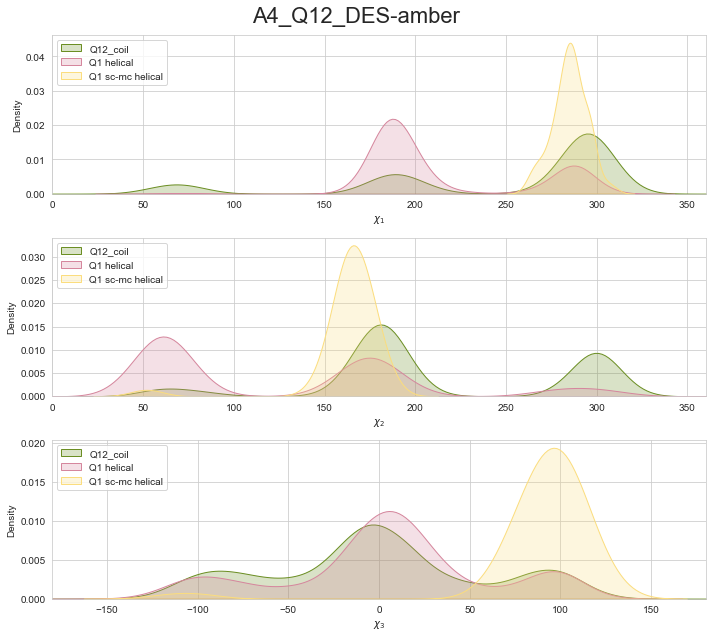

In [53]:
plt.figure(figsize=(10,9))
plt.suptitle('A4_Q12_DES-amber', fontsize=22)
plt.subplot(311)
sns.kdeplot(chis1_Q12_coil,shade=True, label="Q12_coil", color='olivedrab')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
sns.kdeplot(chis1_Q1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chis1_Q1_hhbond,shade=True, label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_1$');
plt.xlim(0,360)

plt.subplot(312)
sns.kdeplot(chis2_Q12_coil,shade=True, label="Q12_coil", color='olivedrab')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
sns.kdeplot(chis2_Q1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chis2_Q1_hhbond,shade=True, label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_2$');
plt.xlim(0,360)

plt.subplot(313)
sns.kdeplot(chis3_Q12_coil,shade=True, label="Q12_coil", color='olivedrab')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
sns.kdeplot(chis3_Q1_helix,shade=True, label="Q1 helical", color='#d5869d') 
sns.kdeplot(chis3_Q1_hhbond,shade=True, label="Q1 sc-mc helical", color='#fbdd7e') 
plt.legend(loc="upper left")
plt.xlabel(r'$\chi_3$');
plt.xlim(-180,180)

plt.tight_layout()


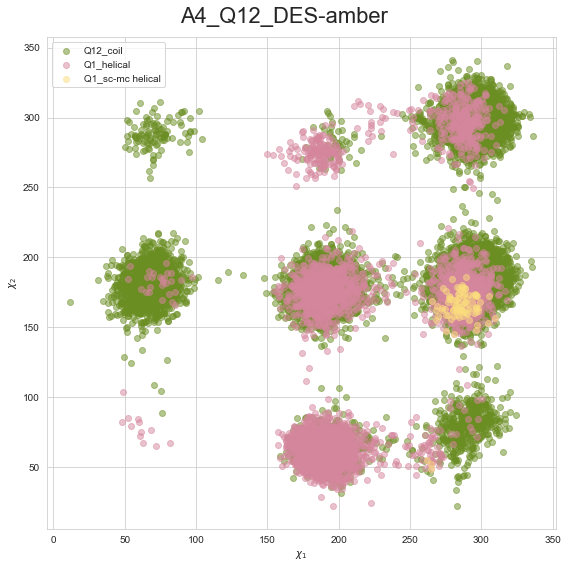

In [54]:
plt.figure(figsize=(8,8))
plt.suptitle('A4_Q12_DES-amber', fontsize=22)
plt.scatter(chis1_Q12_coil,chis2_Q12_coil, marker='o', color='olivedrab', label="Q12_coil", alpha=0.5) 
plt.scatter(chis1_Q1_helix, chis2_Q1_helix, color='#d5869d', marker='o', label="Q1_helical",alpha=0.5) 
plt.scatter(chis1_Q1_hhbond, chis2_Q1_hhbond,color='#fbdd7e', marker='o', label="Q1_sc-mc helical",alpha=0.5 )
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend(loc='best')
plt.tight_layout()

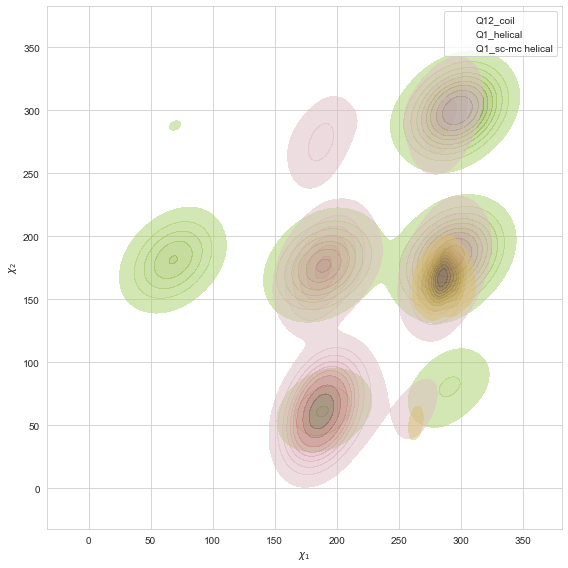

In [39]:
plt.figure(figsize=(8,8))
sns.kdeplot(x=chis1_Q12_coil,y=chis2_Q12_coil, color='olivedrab', shade='fill', label="Q12_coil",alpha=0.5) 
sns.kdeplot(x=chis1_Q1_helix, y=chis2_Q1_helix, color='#d5869d',  shade='fill', label="Q1_helical",alpha=0.5) 
sns.kdeplot(x=chis1_Q1_hhbond, y=chis2_Q1_hhbond, color='#fbdd7e', shade='fill', label="Q1_sc-mc helical",alpha=0.5)
plt.xlabel(r'$\chi_1$');
plt.ylabel(r'$\chi_2$');
plt.legend()
plt.tight_layout()


In [41]:
import collections

#Creating a disctionary where the keys are the different rotamer annotations and the values are the number of times each
#rotamer appears in the trajectory

# DICTIONARY FOR HELICAL Q1

i = 0
j = 0
Q1_helix_rotamers = []

for i,j in zip(chis1_Q1_helix,chis2_Q1_helix):
    if i <=120 and j<=120:
        rot = "g+g+"
        Q1_helix_rotamers.append(rot)
    elif i<= 120 and (j>120 and j<=240):
        rot = "g+t"
        Q1_helix_rotamers.append(rot)
    elif i<= 120 and (j>240 and j<=360):
        rot = "g+g-"
        Q1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and j<=120:
        rot = "tg+"
        Q1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and (j>120 and j<=240):
        rot = "tt"
        Q1_helix_rotamers.append(rot)
    elif (i>120 and i<=240) and (j>240 and j<=360):
        rot = "tg-"
        Q1_helix_rotamers.append(rot)
    elif (i>240 and i<=360) and (j<=120):
        rot = "g-g+"
        Q1_helix_rotamers.append(rot)
    elif (i>240 and i<=360) and (j>120 and j<=240):
        rot = "g-t"
        Q1_helix_rotamers.append(rot)
    else:
        rot = "g-g-"
        Q1_helix_rotamers.append(rot)

df_helix = pd.DataFrame(list(zip(chis1_Q1_helix,chis2_Q1_helix,Q1_helix_rotamers,chis3_Q1_helix)), 
          columns=['chi1','chi2','r1r2RotamersPopulation','chi3'])
print (df_helix)


Q1_helix_RotCount = collections.Counter(Q1_helix_rotamers)
print(Q1_helix_RotCount)
Q1_helix_RotCount['g+g-'] = 0
Q1_helix_RotDict = dict(Q1_helix_RotCount)
Q1_helix_RotSort = dict(sorted(Q1_helix_RotDict.items()))

print (Q1_helix_RotSort)


            chi1        chi2 r1r2RotamersPopulation        chi3
0     292.118927  175.854736                    g-t -122.121811
1     273.864502  170.171005                    g-t  -89.838402
2     284.228149  190.088196                    g-t -101.174934
3     287.912506  174.861923                    g-t -108.131966
4     282.153748  178.616196                    g-t  -80.691551
...          ...         ...                    ...         ...
5334  271.631653  295.496979                   g-g-   -7.844718
5335  285.257385  300.875824                   g-g-  -27.950893
5336  281.940674  296.548370                   g-g-  -20.936766
5337  222.252136  172.219803                     tt   91.843613
5338  223.039978  162.777374                     tt  105.945923

[5339 rows x 4 columns]
Counter({'tg+': 2758, 'g-t': 995, 'tt': 970, 'g-g-': 336, 'tg-': 174, 'g-g+': 67, 'g+t': 27, 'g+g+': 12})
{'g+g+': 12, 'g+g-': 0, 'g+t': 27, 'g-g+': 67, 'g-g-': 336, 'g-t': 995, 'tg+': 2758, 'tg-': 174, 'tt'

In [42]:
# DICTIONARY FOR COIL Q12

k = 0
l = 0
Q12_coil_rotamers = []

for k,l in zip(chis1_Q12_coil,chis2_Q12_coil):
    if k <=120 and l<=120:
        rot2 = "g+g+"
        Q12_coil_rotamers.append(rot2)
    elif k<= 120 and (l>120 and l<=240):
        rot2 = "g+t"
        Q12_coil_rotamers.append(rot2)
    elif k<= 120 and (l>240 and l<=360):
        rot2 = "g+g-"
        Q12_coil_rotamers.append(rot2)
    elif (k>120 and k<=240) and l<=120:
        rot2 = "tg+"
        Q12_coil_rotamers.append(rot2)
    elif (k>120 and k<=240) and (l>120 and l<=240):
        rot2 = "tt"
        Q12_coil_rotamers.append(rot2)
    elif (k>120 and k<=240) and (l>240 and l<=360):
        rot2 = "tg-"
        Q12_coil_rotamers.append(rot2)
    elif (k>240 and k<=360) and (l<=120):
        rot2 = "g-g+"
        Q12_coil_rotamers.append(rot2)
    elif (k>240 and k<=360) and (l>120 and l<=240):
        rot2 = "g-t"
        Q12_coil_rotamers.append(rot2)
    else:
        rot2 = "g-g-"
        Q12_coil_rotamers.append(rot2)

df_coil = pd.DataFrame(list(zip(chis1_Q12_coil,chis2_Q12_coil,Q12_coil_rotamers,chis3_Q12_coil)), 
                  columns=['chi1','chi2','r1r2RotamersPopulation','chi3'])
print (df_coil)

Q12_coil_RotCount = collections.Counter(Q12_coil_rotamers)
print(Q12_coil_RotCount)
Q12_coil_RotDict = dict(Q12_coil_RotCount)
Q12_coil_RotSort = dict(sorted(Q12_coil_RotDict.items()))

print (Q12_coil_RotSort)



             chi1        chi2 r1r2RotamersPopulation        chi3
0      209.320129   66.818230                    tg+  -66.161537
1      213.408234   54.911213                    tg+ -105.712029
2      182.320343   64.545105                    tg+ -128.084122
3      189.182739   47.353909                    tg+ -126.565376
4      199.109207   65.001389                    tg+  -99.692451
...           ...         ...                    ...         ...
16324  304.756714  293.952240                   g-g-    2.604019
16325  295.087921  309.477448                   g-g-  -73.796280
16326  284.882538  289.307098                   g-g-   31.434305
16327  289.274658  308.164398                   g-g-  -90.803047
16328  288.001465  294.246460                   g-g-  -88.837463

[16329 rows x 4 columns]
Counter({'g-g-': 5257, 'g-t': 5181, 'tt': 2923, 'g+t': 1610, 'tg+': 746, 'g-g+': 459, 'g+g-': 107, 'tg-': 43, 'g+g+': 3})
{'g+g+': 3, 'g+g-': 107, 'g+t': 1610, 'g-g+': 459, 'g-g-': 5257, 'g-t': 

In [44]:
# DICTIONARY FOR Hydrogen Bond Forming Q1

e = 0
f = 0
Q1_helix_hbond_rotamers = []

for e,f in zip(chis1_Q1_hhbond,chis2_Q1_hhbond):
    if e<=120 and f<=120:
        rot3 = "g+g+"
        Q1_helix_hbond_rotamers.append(rot3)
    elif e<= 120 and (f>120 and f<=240):
        rot3 = "g+t"
        Q1_helix_hbond_rotamers.append(rot3)
    elif e<= 120 and (f>240 and f<=360):
        rot3 = "g+g-"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and f<=120:
        rot3 = "tg+"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and (f>120 and f<=240):
        rot3 = "tt"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>120 and e<=240) and (f>240 and f<=360):
        rot3 = "tg-"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>240 and e<=360) and (f<=120):
        rot3 = "g-g+"
        Q1_helix_hbond_rotamers.append(rot3)
    elif (e>240 and e<=360) and (f>120 and f<=240):
        rot3 = "g-t"
        Q1_helix_hbond_rotamers.append(rot3)
    else:
        rot3 = "g-g-"
        Q1_helix_hbond_rotamers.append(rot3)

# Dataframe 
df_hbond = pd.DataFrame(list(zip(chis1_Q1_hhbond,chis2_Q1_hhbond,Q1_helix_hbond_rotamers,chis3_Q1_hhbond)), 
                  columns=['chi1','chi2','r1r2RotamersPopulation','chi3'])
print (df_hbond)


Q1_helix_hbond_RotCount = collections.Counter(Q1_helix_hbond_rotamers)
print (Q1_helix_hbond_RotCount)

# This should be modified and get it into  a conditional loop that would be able to check if the dictionary presents 
#all the nine different rotamers population and if not, then add all they are missing
Q1_helix_hbond_RotCount['g+g+'] = 0
Q1_helix_hbond_RotCount['g+g-'] = 0
Q1_helix_hbond_RotCount['g+t'] = 0
Q1_helix_hbond_RotCount['g-g-'] = 0
Q1_helix_hbond_RotCount['tt'] = 0
Q1_helix_hbond_RotCount['tg-'] = 0
Q1_helix_hbond_RotCount['tg+'] = 0
print("Updated Dict is: ", Q1_helix_hbond_RotCount)

Q1_helix_hbond_RotDict = dict(Q1_helix_hbond_RotCount)
Q1_helix_hbond_RotSort = dict(sorted(Q1_helix_hbond_RotDict.items()))

print(Q1_helix_hbond_RotSort)




          chi1        chi2 r1r2RotamersPopulation        chi3
0   279.894196  162.127884                    g-t   93.286545
1   295.941437  160.610626                    g-t  102.859474
2   277.160431  172.160416                    g-t   93.245110
3   280.437866  145.430786                    g-t  108.696434
4   288.746002  167.841034                    g-t  112.971504
..         ...         ...                    ...         ...
89  276.658020  168.348419                    g-t   91.406151
90  284.701599  161.490479                    g-t   93.396233
91  289.486084  167.410431                    g-t  103.760216
92  277.459869  170.415756                    g-t   83.077187
93  293.404449  168.145721                    g-t   97.670357

[94 rows x 4 columns]
Counter({'g-t': 91, 'g-g+': 3})
Updated Dict is:  Counter({'g-t': 91, 'g-g+': 3, 'g+g+': 0, 'g+g-': 0, 'g+t': 0, 'g-g-': 0, 'tt': 0, 'tg-': 0, 'tg+': 0})
{'g+g+': 0, 'g+g-': 0, 'g+t': 0, 'g-g+': 3, 'g-g-': 0, 'g-t': 91, 'tg+': 0, 'tg

Text(0, 0.5, 'Total Number')

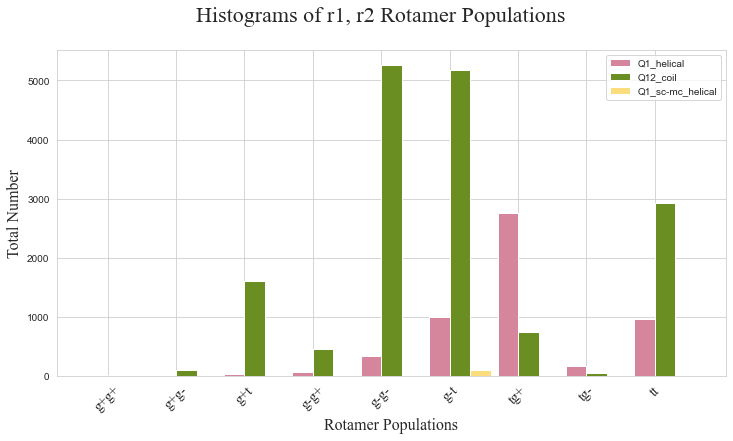

In [45]:
fig = plt.figure(figsize=(12,6)) 
sns.set_style('whitegrid')
ind = np.arange(9)
width = 0.30  
categories = ['g+g+','g+g-','g+t','g-g+','g-g-','g-t','tg+','tg-','tt']
csfont = {'fontname':'Times New Roman'}

plt.bar(ind, Q1_helix_RotSort.values(), width, label="Q1_helical", color="#d5869d", align="edge")
plt.bar(ind+width, Q12_coil_RotSort.values(), width, label="Q12_coil", color="olivedrab", align="edge")
plt.bar(ind+2*width, Q1_helix_hbond_RotSort.values(), width, label="Q1_sc-mc_helical", color="#fbdd7e", align="edge")
plt.xticks(ind + width, categories, fontsize=14, rotation=45, **csfont)
plt.legend(loc="best")
fig.suptitle('Histograms of r1, r2 Rotamer Populations', fontsize=22, **csfont)
plt.xlabel('Rotamer Populations', fontsize=16, **csfont)
plt.ylabel('Total Number', fontsize=16, **csfont)


Now, it would be a good approach to study the total pertentaje of each r1r2 rotamers (depending on the secondary structure it addopts) instead of the total number. 

In [46]:
# Function to modify each value of the dictionary
def mutate_dict(f,d):
    for k, v in d.items():
        d[k] = f(v)

# Helical Q1 
values_Q1H = Q1_helix_RotSort.values()
print(values_Q1H)
factor1 = 100/sum(values_Q1H)
print(factor1)

mutate_dict(lambda x: x*factor1, Q1_helix_RotSort)
print (Q1_helix_RotSort)
    

#Coil Q12 
values_Q12C = Q12_coil_RotSort.values()
print(values_Q12C)
factor2 = 100/sum(values_Q12C)
print(factor2)

mutate_dict(lambda x: x*factor2, Q12_coil_RotSort)
print (Q12_coil_RotSort)


# Q1 forming a sc-mc hydrogen bond with L1
values_Q1HH = Q1_helix_hbond_RotSort.values()
print(values_Q1HH)
factor3 = 100/sum(values_Q1HH)
print(factor3)

mutate_dict(lambda x: x*factor3, Q1_helix_hbond_RotSort)
print (Q1_helix_hbond_RotSort)

dict_values([12, 0, 27, 67, 336, 995, 2758, 174, 970])
0.018730099269526127
{'g+g+': 0.22476119123431354, 'g+g-': 0.0, 'g+t': 0.5057126802772054, 'g-g+': 1.2549166510582506, 'g-g-': 6.2933133545607784, 'g-t': 18.636448773178497, 'tg+': 51.65761378535306, 'tg-': 3.259037272897546, 'tt': 18.168196291440342}
dict_values([3, 107, 1610, 459, 5257, 5181, 746, 43, 2923])
0.006124073733847756
{'g+g+': 0.01837222120154327, 'g+g-': 0.6552758895217099, 'g+t': 9.859758711494887, 'g-g+': 2.81094984383612, 'g-g-': 32.19425561883765, 'g-t': 31.728826015065223, 'tg+': 4.5685590054504255, 'tg-': 0.2633351705554535, 'tt': 17.90066752403699}
dict_values([0, 0, 0, 3, 0, 91, 0, 0, 0])
1.0638297872340425
{'g+g+': 0.0, 'g+g-': 0.0, 'g+t': 0.0, 'g-g+': 3.1914893617021276, 'g-g-': 0.0, 'g-t': 96.80851063829788, 'tg+': 0.0, 'tg-': 0.0, 'tt': 0.0}


Text(0, 0.5, 'Percent of total')

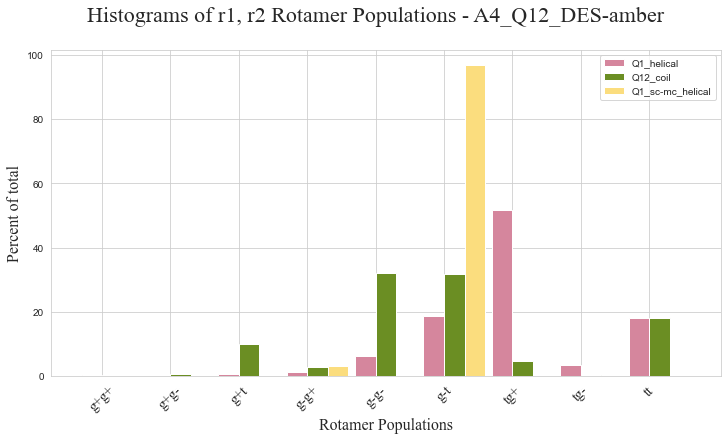

In [48]:
fig = plt.figure(figsize=(12,6)) 
sns.set_style('whitegrid')
ind = np.arange(9)
width = 0.30  
categories = ['g+g+','g+g-','g+t','g-g+','g-g-','g-t','tg+','tg-','tt']
csfont = {'fontname':'Times New Roman'}

plt.bar(ind, Q1_helix_RotSort.values(), width, label="Q1_helical", color="#d5869d", align="edge")
plt.bar(ind+width, Q12_coil_RotSort.values(), width, label="Q12_coil", color="olivedrab", align="edge")
plt.bar(ind+2*width, Q1_helix_hbond_RotSort.values(), width, label="Q1_sc-mc_helical", color="#fbdd7e", align="edge")
plt.xticks(ind + width, categories, fontsize=14, rotation=45, **csfont)
plt.legend(loc="best")
fig.suptitle('Histograms of r1, r2 Rotamer Populations - A4_Q12_DES-amber', fontsize=22, **csfont)
plt.xlabel('Rotamer Populations', fontsize=16, **csfont)
plt.ylabel('Percent of total', fontsize=16, **csfont)


### r3 Kernel Density Analysis

#### The backbone-independent distribution of nonrotameric χ3 of Gln for each of its (χ1, χ2) rotamers. 

Nonrotameric χ3 distributions for Gln are dependent on both the χ1 and χ2 rotamers. The distributions of the nonrotameric degrees of freedom are very broad and asymmetric and cannot be modeled with a rotameric model (Shapovalov & Dunbrack Jr, 2011)

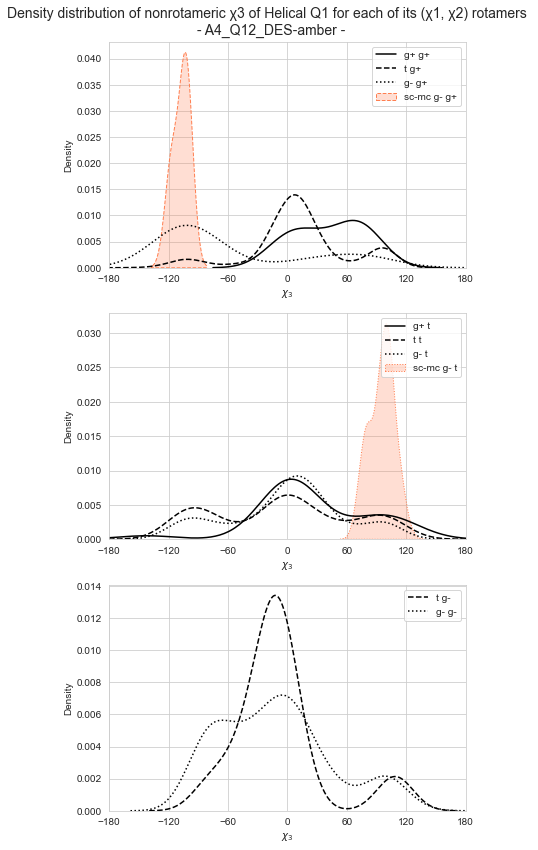

In [51]:
# We are going to use the created dataframes for each Gln condition

# HELICAL Q1 --> dataframe = df_helix

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Helical Q1 for each of its (χ1, χ2) rotamers \n - A4_Q12_DES-amber -', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g+"'), x="chi3", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg+"'), x="chi3", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle="--", label="sc-mc g- g+",color="coral",shade=True)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle=":", label="g- g+",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+t"'), x="chi3", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tt"'), x="chi3", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="sc-mc g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g+g-"'), x="chi3", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "tg-"'), x="chi3", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_helix.query('r1r2RotamersPopulation == "g-g-"'), x="chi3", linestyle=":", label="g- g-",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()

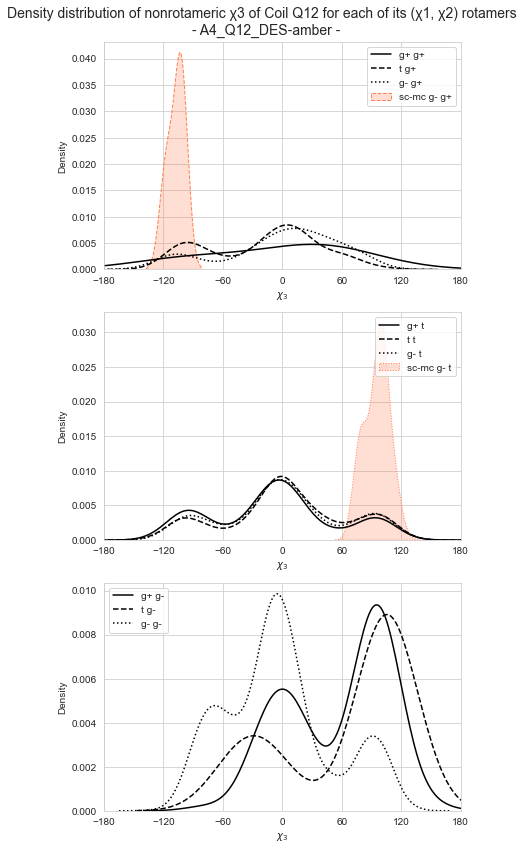

In [52]:
# We are going to use the created dataframes for each Gln condition

# COIL Q12 --> dataframe = df_coil

plt.figure(figsize=(6,12)) 
sns.set_style('whitegrid')
plt.suptitle('Density distribution of nonrotameric χ3 of Coil Q12 for each of its (χ1, χ2) rotamers \n - A4_Q12_DES-amber -', fontsize=14)
angles = [-180,-120,-60,0,60,120,180]

plt.subplot(311)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g+"'), x="chi3", linestyle="-", label="g+ g+", color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg+"'), x="chi3", linestyle="--", label="t g+",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle="--", label="sc-mc g- g+",color="coral",shade=True)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g+"'), x="chi3", linestyle=":", label="g- g+",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(312)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+t"'), x="chi3", linestyle="-", label="g+ t", color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tt"'), x="chi3", linestyle="--", label="t t",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="g- t",color="k")
sns.kdeplot(data=df_hbond.query('r1r2RotamersPopulation == "g-t"'), x="chi3", linestyle=":", label="sc-mc g- t",color="coral", shade=True)
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.subplot(313)
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g+g-"'), x="chi3", linestyle="-", label="g+ g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "tg-"'), x="chi3", linestyle="--", label="t g-",color="k")
sns.kdeplot(data=df_coil.query('r1r2RotamersPopulation == "g-g-"'), x="chi3", linestyle=":", label="g- g-",color="k")
plt.legend(loc="best")
plt.xlabel(r'$\chi_3$')
plt.xlim(-180,180)
plt.xticks(angles)

plt.tight_layout()